In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-multilearn==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix
import os

# Data Handling
import os
import re
import string
import numpy as np
import pandas as pd

# NLP Preprocessing
# import nltk
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Machine Learning & Model Evaluation
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    confusion_matrix, accuracy_score
)
# from skmultilearn.adapt import MLkNN

# Deep Learning (Keras & TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l1.csv')
d2= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l2.csv')
d3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l3.csv')
d1

,text,key,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6
0,"This is our history . For Shia and Sunni ,...",question_1,NaN,NaN,NaN,NaN,NaN,0.0
1,"If this is ""grilling"" then wht wud u call t...",question_1,NaN,NaN,NaN,1.0,NaN,NaN
2,look at <handle replaced>madam. Locals attac...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
3,our beloved yogi ji has given money home and...,question_1,NaN,NaN,NaN,NaN,1.0,NaN
4,"""I gonna kill that bitch"" Bitvj imma kill you...",question_1,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
6526,“mama let’s research” bitch suck my dick 😭,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6527,😂😂😂😂 I WAS BY MYSELF AND IT WAS HER AND HER BI...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6528,😂😂😂😂😂😂😂😂😂 i just seen a comment and bitch IM C...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6529,"😎""Boys Only Luxury!!!!!!!!!!!!!!!!!!!!!!!!!!!""...",question_1,0.0,1.0,1.0,0.0,NaN,NaN


In [5]:
# Word Pre-Processing

def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d2['text'] = d2['text'].apply(lambda x: normalize_text(x))
d3['text'] = d3['text'].apply(lambda x: normalize_text(x))


# Train Test Splits

In [6]:
X1 = list(d1['text'])
X2 = list(d2['text'])
X3 = list(d3['text'])

col_lst = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d2[col] = pd.to_numeric(d2[col], errors='coerce')
    d3[col] = pd.to_numeric(d3[col], errors='coerce')

d1['label'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d2['label'] = d2[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d3['label'] = d3[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d1 = d1.drop(col_lst, axis=1)
d2 = d2.drop(col_lst, axis=1)
d3 = d3.drop(col_lst, axis=1)

d1['label'] = d1['label'].astype(int)
d2['label'] = d2['label'].astype(int)
d3['label'] = d3['label'].astype(int)

d1 = d1[['label', 'text']]
d2 = d2[['label', 'text']]
d3 = d3[['label', 'text']]
d2

,label,text
0,0,this is our history for shia and sunni ...
1,1,if this is grilling then wht wud u call t...
2,0,look at madam locals attacked no religion...
3,1,our beloved yogi ji has given money home and...
4,1,i gonna kill that bitch bitvj imma kill you...
...,...,...
6526,0,“mama let’s research” bitch suck my dick
6527,0,i was by myself and it was her and her bitch ...
6528,0,i just seen a comment and bitch im cryinnnnnn...
6529,1,boys only luxury ...


In [7]:
y_data1 = d1["label"]
y_data2 = d2["label"]
y_data3 = d3["label"]
# print(y_data)
y1 = y_data1.values
y2 = y_data2.values
y3 = y_data3.values
print(y1)
print(len(y1))
print(y2)
print(len(y2))
print(y3)
print(len(y3))

[0 1 0 ... 0 1 0]
6531
[0 1 0 ... 0 1 0]
6531
[0 1 0 ... 0 1 0]
6531


# Model CNN & Bi-LSTM

In [8]:
#Model CNN & Bi-LSTM
######## Textual Features for Embedding ###################
max_len = 100
max_features = 4479
embed_size = 300
tokenizer1 = Tokenizer(num_words=max_features)
tokenizer2 = Tokenizer(num_words=max_features)
tokenizer3 = Tokenizer(num_words=max_features)

tokenizer1.fit_on_texts(list(X1))
tokenizer2.fit_on_texts(list(X2))
tokenizer3.fit_on_texts(list(X3))

X1 = tokenizer1.texts_to_sequences(X1)
X2 = tokenizer2.texts_to_sequences(X2)
X3 = tokenizer3.texts_to_sequences(X3)

X1 = pad_sequences(X1, padding='post', maxlen=max_len)
X2 = pad_sequences(X2, padding='post', maxlen=max_len)
X3 = pad_sequences(X3, padding='post', maxlen=max_len)

In [9]:
######### Label Encoding for y_train & y_test################
from sklearn.preprocessing import LabelEncoder

label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
label_encoder3 = LabelEncoder()
y1 = label_encoder1.fit_transform(y1)
y2 = label_encoder2.fit_transform(y2)
y3 = label_encoder3.fit_transform(y3)
y1
# print(len(y))

array([0, 1, 0, ..., 0, 1, 0])

In [10]:
y1 = to_categorical(y1, num_classes=2)
y2 = to_categorical(y2, num_classes=2)
y3 = to_categorical(y3, num_classes=2)
y1

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/NLP_Project/NLP/glove.42B.300d.txt', encoding="utf8") ## using pre-trained or self-trained embeddings ##

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

vocab_size = len(tokenizer1.word_index) + 1  ## total distinct words is the Vocabulary ##
word_index = tokenizer1.word_index
num_words = min(max_features,len(word_index)+1)

embedding_matrix = zeros((num_words, embed_size)) ## has to be similar to glove dimension ##
for word, index in tokenizer1.word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Model Training

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D, Dropout, Conv1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input


# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a list to store classification reports for each fold
classification_reports = []
# Initialize lists to store metrics for each fold
precision_list = []
recall_list = []
f1_score_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X1, y1)):
    X_train_1, X_val_1 = X1[train_index], X1[val_index]
    y_train_1, y_val_1 = y1[train_index], y1[val_index]

    # Define the model architecture
    sequence_input = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    #x = Conv1D(16, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    x = Dense(128,activation='relu')(avg_pool)
    x = Dropout(0.2)(x)
    preds = Dense(2, activation="softmax")(x)
    model1 = Model(sequence_input, preds)
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    epochs = 15
    batch_size = 128
    history = model1.fit(X_train_1, y_train_1, epochs=epochs, batch_size=batch_size, validation_data=(X_val_1, y_val_1), verbose=1)

    # Evaluate the model on the validation data
    y_pred_1 = model1.predict(X_val_1)
    y_pred_labels = np.argmax(y_pred_1, axis=1)
    y_val_labels = np.argmax(y_val_1, axis=1)

#     # Generate and store the classification report for this fold
#     report = classification_report(y_val_labels, y_pred_labels, target_names=['neither', 'racist', 'sexist'])
#     classification_reports.append(report)

#     print(f'Fold {fold + 1} - Classification Report:\n{report}\n')

# # Print the average classification report across all folds
# average_report = '\n'.join(classification_reports)
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')
     # Generate the classification report for this fold
    report = classification_report(y_val_labels, y_pred_labels, target_names=['Hate', 'Not Hate'], output_dict=True)

    # Extract precision, recall, and f1-score
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_score_list.append(report['weighted avg']['f1-score'])

    print(f'Fold {fold + 1} - Classification Report:\n{classification_report(y_val_labels, y_pred_labels, target_names=["Hate", "Not Hate"])}\n')

# Calculate the average precision, recall, and f1-score across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Display the average classification report
average_report = f'Average Precision: {average_precision:.2f}\nAverage Recall: {average_recall:.2f}\nAverage F1-Score: {average_f1_score:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7397 - loss: 0.5817 - val_accuracy: 0.7860 - val_loss: 0.5045
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7924 - loss: 0.4858 - val_accuracy: 0.7863 - val_loss: 0.4548
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7977 - loss: 0.4435 - val_accuracy: 0.7961 - val_loss: 0.4444
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8063 - loss: 0.4311 - val_accuracy: 0.7890 - val_loss: 0.4407
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8133 - loss: 0.4149 - val_accuracy: 0.7952 - val_loss: 0.4330
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8064 - loss: 0.4247 - val_accuracy: 0.7976 - val_loss: 0.4652
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8231 - loss: 0.4118 - val_accuracy: 0.7952 - val_loss: 0.4325
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8158 - loss: 0.4048 - val_accuracy: 0.8007 - val_loss:

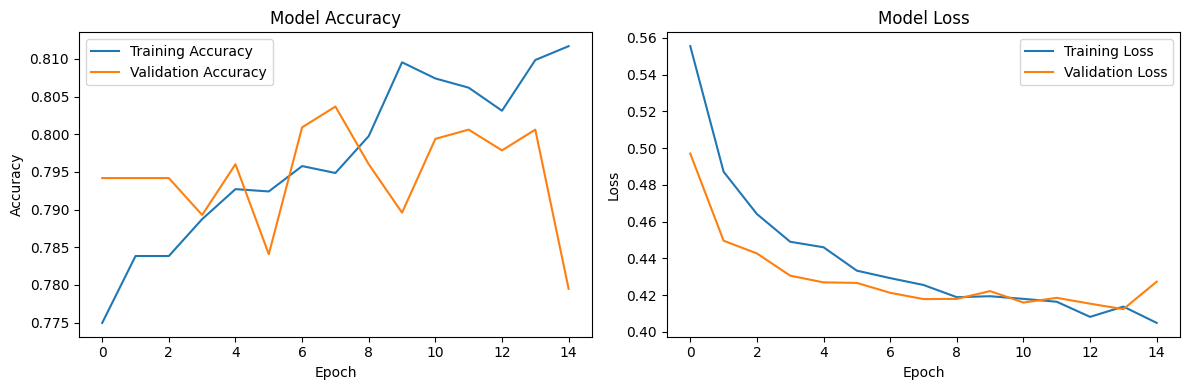

In [13]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(report)

F1 Score: 0.7835334288416944
Precision: 0.7883825757428052
Recall: 0.77947932618683
{'Hate': {'precision': 0.871479571598572, 'recall': 0.8472811415349016, 'f1-score': 0.859210011732499, 'support': 2593.0}, 'Not Hate': {'precision': 0.46774193548387094, 'recall': 0.5178571428571429, 'f1-score': 0.4915254237288136, 'support': 672.0}, 'accuracy': 0.77947932618683, 'macro avg': {'precision': 0.6696107535412215, 'recall': 0.6825691421960223, 'f1-score': 0.6753677177306563, 'support': 3265.0}, 'weighted avg': {'precision': 0.7883825757428052, 'recall': 0.77947932618683, 'f1-score': 0.7835334288416944, 'support': 3265.0}}


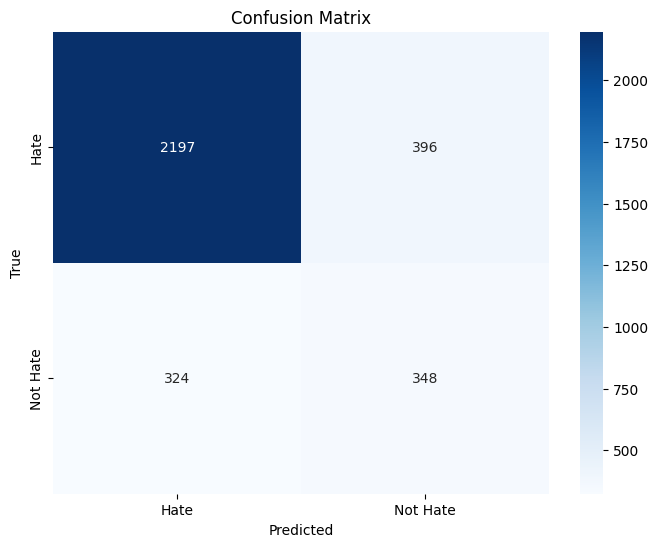

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
model1.save('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification_1.h5')

In [17]:
# Initialize a list to store classification reports for each fold
classification_reports = []
# Initialize lists to store metrics for each fold
precision_list = []
recall_list = []
f1_score_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X2, y2)):
    X_train_2, X_val_2 = X2[train_index], X2[val_index]
    y_train_2, y_val_2 = y2[train_index], y2[val_index]

    # Define the model architecture
    sequence_input = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    #x = Conv1D(16, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    x = Dense(128,activation='relu')(avg_pool)
    x = Dropout(0.2)(x)
    preds = Dense(2, activation="softmax")(x)
    model2 = Model(sequence_input, preds)
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    epochs = 15
    batch_size = 128
    history = model2.fit(X_train_2, y_train_2, epochs=epochs, batch_size=batch_size, validation_data=(X_val_2, y_val_2), verbose=1)

    # Evaluate the model on the validation data
    y_pred_2 = model2.predict(X_val_2)
    y_pred_labels = np.argmax(y_pred_2, axis=1)
    y_val_labels = np.argmax(y_val_2, axis=1)

#     # Generate and store the classification report for this fold
#     report = classification_report(y_val_labels, y_pred_labels, target_names=['neither', 'racist', 'sexist'])
#     classification_reports.append(report)

#     print(f'Fold {fold + 1} - Classification Report:\n{report}\n')

# # Print the average classification report across all folds
# average_report = '\n'.join(classification_reports)
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')
     # Generate the classification report for this fold
    report = classification_report(y_val_labels, y_pred_labels, target_names=['Hate', 'Not Hate'], output_dict=True)

    # Extract precision, recall, and f1-score
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_score_list.append(report['weighted avg']['f1-score'])

    print(f'Fold {fold + 1} - Classification Report:\n{classification_report(y_val_labels, y_pred_labels, target_names=["Hate", "Not Hate"])}\n')

# Calculate the average precision, recall, and f1-score across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Display the average classification report
average_report = f'Average Precision: {average_precision:.2f}\nAverage Recall: {average_recall:.2f}\nAverage F1-Score: {average_f1_score:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6294 - loss: 0.6644 - val_accuracy: 0.6733 - val_loss: 0.6175
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6840 - loss: 0.5983 - val_accuracy: 0.6721 - val_loss: 0.5983
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6866 - loss: 0.5914 - val_accuracy: 0.6908 - val_loss: 0.5762
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6829 - loss: 0.5819 - val_accuracy: 0.7048 - val_loss: 0.5701
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7179 - loss: 0.5589 - val_accuracy: 0.7100 - val_loss: 0.5670
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7168 - loss: 0.5668 - val_accuracy: 0.7094 - val_loss: 0.5738
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7163 - loss: 0.5610 - val_accuracy: 0.7143 - val_loss: 0.5645
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7192 - loss: 0.5574 - val_accuracy: 0.7162 - val_loss:

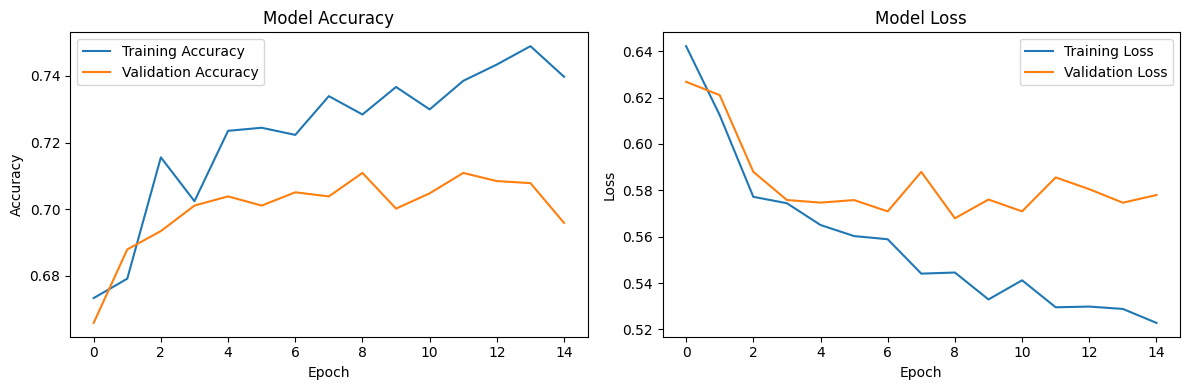

In [18]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
model2.save('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification_2.h5')

In [20]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(report)

F1 Score: 0.6783482301066581
Precision: 0.6779708530969245
Recall: 0.695865237366003
{'Hate': {'precision': 0.7342324474414915, 'recall': 0.8514259429622815, 'f1-score': 0.7884984025559105, 'support': 2174.0}, 'Not Hate': {'precision': 0.5658602150537635, 'recall': 0.38588450962419796, 'f1-score': 0.4588555858310627, 'support': 1091.0}, 'accuracy': 0.695865237366003, 'macro avg': {'precision': 0.6500463312476275, 'recall': 0.6186552262932397, 'f1-score': 0.6236769941934865, 'support': 3265.0}, 'weighted avg': {'precision': 0.6779708530969245, 'recall': 0.695865237366003, 'f1-score': 0.6783482301066581, 'support': 3265.0}}


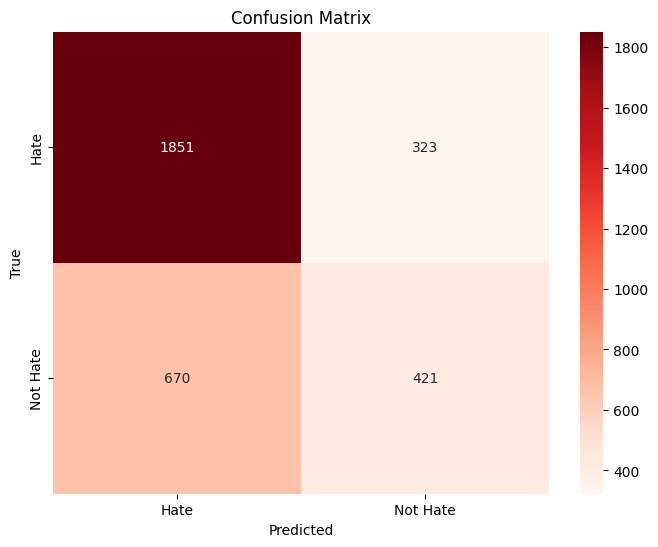

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Initialize a list to store classification reports for each fold
classification_reports = []
# Initialize lists to store metrics for each fold
precision_list = []
recall_list = []
f1_score_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X3, y3)):
    X_train_3, X_val_3 = X3[train_index], X3[val_index]
    y_train_3, y_val_3 = y3[train_index], y3[val_index]

    # Define the model architecture
    sequence_input = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    #x = Conv1D(16, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    x = Dense(128,activation='relu')(avg_pool)
    x = Dropout(0.2)(x)
    preds = Dense(2, activation="softmax")(x)
    model3 = Model(sequence_input, preds)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    epochs = 15
    batch_size = 128
    history = model3.fit(X_train_3, y_train_3, epochs=epochs, batch_size=batch_size, validation_data=(X_val_3, y_val_3), verbose=1)

    # Evaluate the model on the validation data
    y_pred_3 = model2.predict(X_val_3)
    y_pred_labels = np.argmax(y_pred_3, axis=1)
    y_val_labels = np.argmax(y_val_3, axis=1)

#     # Generate and store the classification report for this fold
#     report = classification_report(y_val_labels, y_pred_labels, target_names=['neither', 'racist', 'sexist'])
#     classification_reports.append(report)

#     print(f'Fold {fold + 1} - Classification Report:\n{report}\n')

# # Print the average classification report across all folds
# average_report = '\n'.join(classification_reports)
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')
     # Generate the classification report for this fold
    report = classification_report(y_val_labels, y_pred_labels, target_names=['Hate', 'Not Hate'], output_dict=True)

    # Extract precision, recall, and f1-score
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_score_list.append(report['weighted avg']['f1-score'])

    print(f'Fold {fold + 1} - Classification Report:\n{classification_report(y_val_labels, y_pred_labels, target_names=["Hate", "Not Hate"])}\n')

# Calculate the average precision, recall, and f1-score across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Display the average classification report
average_report = f'Average Precision: {average_precision:.2f}\nAverage Recall: {average_recall:.2f}\nAverage F1-Score: {average_f1_score:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6223 - loss: 0.6735 - val_accuracy: 0.6396 - val_loss: 0.6417
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6482 - loss: 0.6337 - val_accuracy: 0.6381 - val_loss: 0.6037
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6666 - loss: 0.5978 - val_accuracy: 0.6552 - val_loss: 0.6097
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6682 - loss: 0.5993 - val_accuracy: 0.6718 - val_loss: 0.5923
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6904 - loss: 0.5833 - val_accuracy: 0.6758 - val_loss: 0.5904
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6726 - loss: 0.5856 - val_accuracy: 0.6739 - val_loss: 0.5890
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6892 - loss: 0.5820 - val_accuracy: 0.6846 - val_loss: 0.5923
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6809 - loss: 0.5842 - val_accuracy: 0.6831 - val_loss:

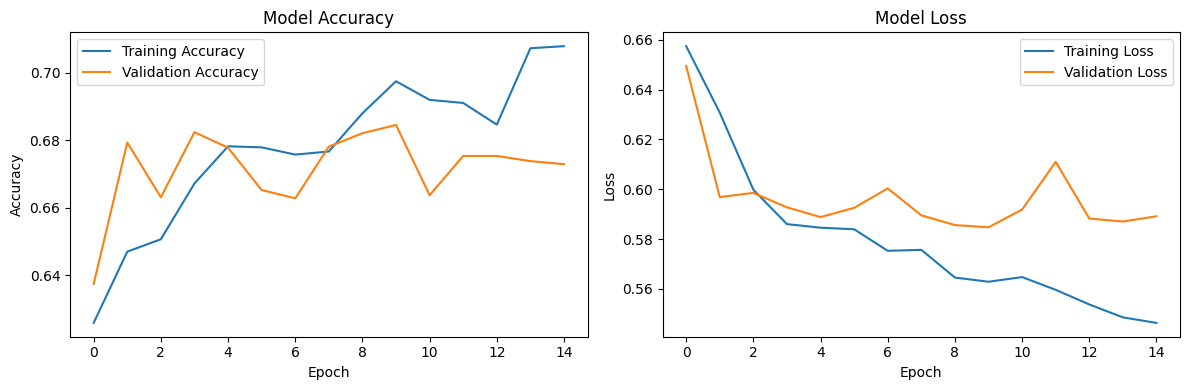

In [23]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(report)

F1 Score: 0.632563089367568
Precision: 0.635299511373151
Recall: 0.655436447166922
{'Hate': {'precision': 0.689408964696549, 'recall': 0.8355769230769231, 'f1-score': 0.7554879374049119, 'support': 2080.0}, 'Not Hate': {'precision': 0.5403225806451613, 'recall': 0.3392405063291139, 'f1-score': 0.416796267496112, 'support': 1185.0}, 'accuracy': 0.655436447166922, 'macro avg': {'precision': 0.6148657726708551, 'recall': 0.5874087147030185, 'f1-score': 0.586142102450512, 'support': 3265.0}, 'weighted avg': {'precision': 0.635299511373151, 'recall': 0.655436447166922, 'f1-score': 0.632563089367568, 'support': 3265.0}}


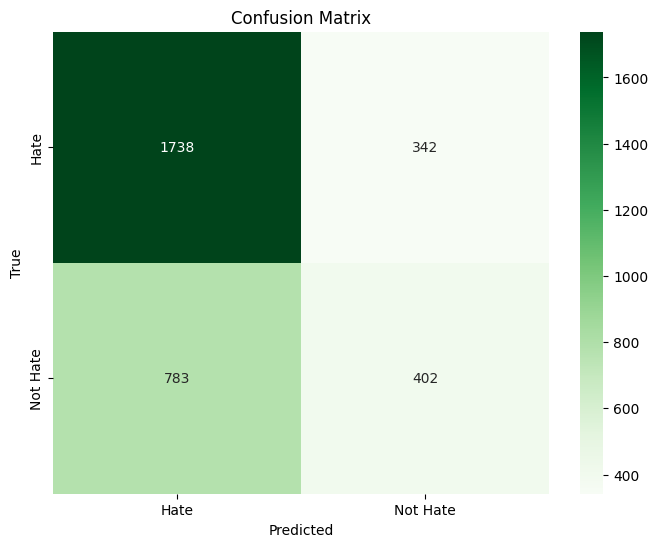

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
model3.save('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification_3.h5')

# Testing on Unseen Data

In [27]:
vv_1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l1.csv')
vv_2= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l2.csv')
vv_3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l3.csv')
vv_1


,text,key,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6
0,"""who's this tweet about"" bitch it's about you ...",question_1,NaN,0.0,NaN,NaN,0.0,1.0
1,#AlkaLamba should’ve used her slippers to slap...,question_1,0.0,0.0,NaN,0.0,NaN,NaN
2,#CoronaVillains #COVIDIDIOT #COVID2019 is a...,question_1,NaN,NaN,1.0,NaN,1.0,1.0
3,"(Acts 29:19994) LIKE the female ""governors"" of...",question_1,NaN,1.0,1.0,NaN,1.0,NaN
4,***Let us celebrate “secular” as a beautiful w...,question_1,NaN,0.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
1102,you should be tired of not having any kind of ...,question_1,0.0,NaN,1.0,NaN,NaN,1.0
1103,“The limits of tyrants are prescribed by the e...,question_1,0.0,NaN,0.0,NaN,0.0,NaN
1104,♋️🦀 like wtf my symbol is 69 and I’m a crab an...,question_1,NaN,NaN,0.0,NaN,0.0,1.0
1105,"🇺🇸: marry a millionaire guy, divorce get half ...",question_1,NaN,NaN,1.0,NaN,1.0,1.0


In [28]:
vv1=vv_1
vv2=vv_2
vv3=vv_3

In [29]:
from tensorflow import keras
from tensorflow.keras.models import load_model

model1 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification_1.h5')
model2 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification_2.h5')
model3 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification_3.h5')

In [30]:
vv_1['text'] = vv_1['text'].apply(lambda x: normalize_text(x))
vv_2['text'] = vv_2['text'].apply(lambda x: normalize_text(x))
vv_3['text'] = vv_3['text'].apply(lambda x: normalize_text(x))
# vv['text'] = vv['text'].apply(lambda x: normalize_text_2(x))
vv_1 = vv_1[['text']]
vv_2 = vv_2[['text']]
vv_3 = vv_3[['text']]
vv_1.columns = ['text']
vv_2.columns = ['text']
vv_3.columns = ['text']
vv_1

,text
0,who s this tweet about bitch it s about you ...
1,alkalamba should’ve used her slippers to slap...
2,coronavillains covididiot is a do...
3,acts like the female governors of stat...
4,let us celebrate “secular” as a beautiful w...
...,...
1102,you should be tired of not having any kind of ...
1103,“the limits of tyrants are prescribed by the e...
1104,like wtf my symbol is and i’m a crab and we...
1105,marry a millionaire guy divorce get half hi...


In [31]:
######## Textual Features for Embedding ###################

sequence1 = tokenizer1.texts_to_sequences(vv_1.text)
sequence1 = pad_sequences(sequence1, padding='post', maxlen=max_len)

sequence2 = tokenizer2.texts_to_sequences(vv_2.text)
sequence2 = pad_sequences(sequence2, padding='post', maxlen=max_len)

sequence3 = tokenizer3.texts_to_sequences(vv_3.text)
sequence3 = pad_sequences(sequence3, padding='post', maxlen=max_len)

In [32]:
sequence1 = tokenizer1.texts_to_sequences(vv_1['text']) # same tokenizer which is used on train data.
sequence1 = pad_sequences(sequence1, padding='post', maxlen = max_len)

sequence2 = tokenizer2.texts_to_sequences(vv_1['text']) # same tokenizer which is used on train data.
sequence2 = pad_sequences(sequence2, padding='post', maxlen = max_len)

sequence3 = tokenizer3.texts_to_sequences(vv_1['text']) # same tokenizer which is used on train data.
sequence3 = pad_sequences(sequence3, padding='post', maxlen = max_len)


In [33]:
predictions1 = model1.predict(sequence1)
classes1 = np.argmax(predictions1, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step


In [34]:
predictions2 = model2.predict(sequence2)
classes2 = np.argmax(predictions2, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step


In [35]:
predictions3 = model3.predict(sequence3)
classes3 = np.argmax(predictions3, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


In [36]:
predictions1

array([[0.3957322 , 0.6042678 ],
       [0.40642667, 0.59357333],
       [0.9383026 , 0.0616974 ],
       ...,
       [0.58970517, 0.41029486],
       [0.3283265 , 0.6716735 ],
       [0.90322304, 0.09677694]], dtype=float32)

In [37]:
print(len(predictions1))

1107


In [38]:
# Assign label 0 if the left probability is higher, otherwise label 1
predictions1 = np.argmax(predictions1, axis=1)
predictions2 = np.argmax(predictions2, axis=1)
predictions3 = np.argmax(predictions3, axis=1)
# predictions = 1 - predictions

# Display the resulting array of predictions
print(predictions1)

[1 1 0 ... 0 1 0]


In [39]:
# X = list(vv1['text'])
#y = np.asarray(d1[d1.columns[1:]])
col_lst = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
for col in col_lst:
    vv1[col] = pd.to_numeric(vv1[col], errors='coerce')
    vv2[col] = pd.to_numeric(vv2[col], errors='coerce')
    vv3[col] = pd.to_numeric(vv3[col], errors='coerce')


vv1['label'] = vv1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
vv2['label'] = vv2[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
vv3['label'] = vv3[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

vv1['label'] = vv1['label'].astype(int)
vv2['label'] = vv2['label'].astype(int)
vv3['label'] = vv3['label'].astype(int)

vv1 = vv1[['label', 'text']]
vv2 = vv2[['label', 'text']]
vv3 = vv3[['label', 'text']]
vv1

true_1 = vv1["label"]
true_2 = vv2["label"]
true_3 = vv3["label"]
# print(true_)
y_test_1 = true_1.values
y_test_2 = true_2.values
y_test_3 = true_3.values
print(y_test_1)
print(len(y_test_1))

[1 0 1 ... 1 1 1]
1107


In [40]:
ids = np.arange(1, len(y_test_1)+1)
result_df_1 = pd.DataFrame({'id': ids, 'prediction': predictions1, 'true': y_test_1})
# result_df_1

ids = np.arange(1, len(y_test_2)+1)
result_df_2 = pd.DataFrame({'id': ids, 'prediction': predictions2, 'true': y_test_2})
# result_df_2

ids = np.arange(1, len(y_test_3)+1)
result_df_3 = pd.DataFrame({'id': ids, 'prediction': predictions3, 'true': y_test_3})
result_df_3

,id,prediction,true
0,1,1,1
1,2,1,0
2,3,0,1
3,4,0,1
4,5,0,1
...,...,...,...
1102,1103,1,1
1103,1104,0,0
1104,1105,0,1
1105,1106,1,1


In [41]:
def compute_metrics(result_df, color):
    # Compute metrics
    accuracy = accuracy_score(result_df['true'], result_df['prediction'])
    f1 = f1_score(result_df['true'], result_df['prediction'], average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
    recall = recall_score(result_df['true'], result_df['prediction'], average='weighted')
    precision = precision_score(result_df['true'], result_df['prediction'], average='weighted')
    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix)

    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color, xticklabels=set(result_df['true']), yticklabels=set(result_df['true']))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 0.7082
F1 Score: 0.6866
Recall: 0.7082
Precision: 0.7293


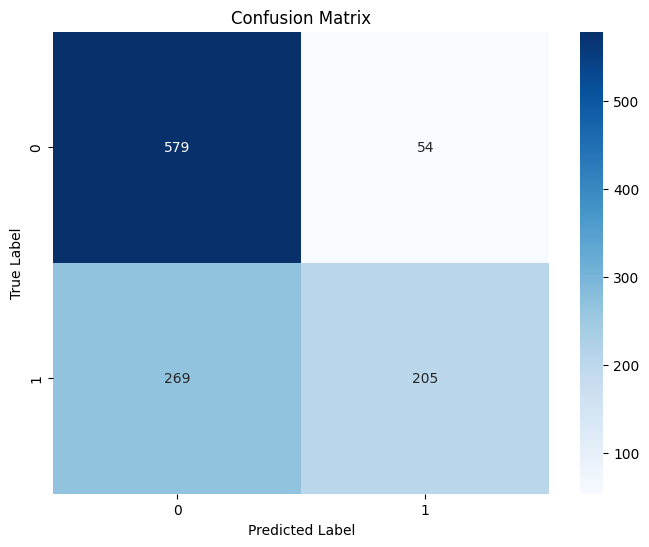

In [42]:
compute_metrics(result_df_1, "Blues")

Accuracy: 0.4968
F1 Score: 0.4724
Recall: 0.4968
Precision: 0.7196


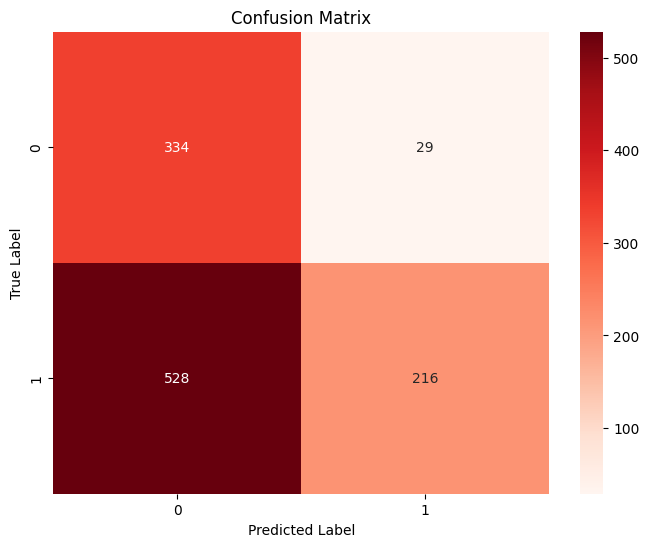

In [43]:
compute_metrics(result_df_2, "Reds")

Accuracy: 0.6107
F1 Score: 0.6020
Recall: 0.6107
Precision: 0.7312


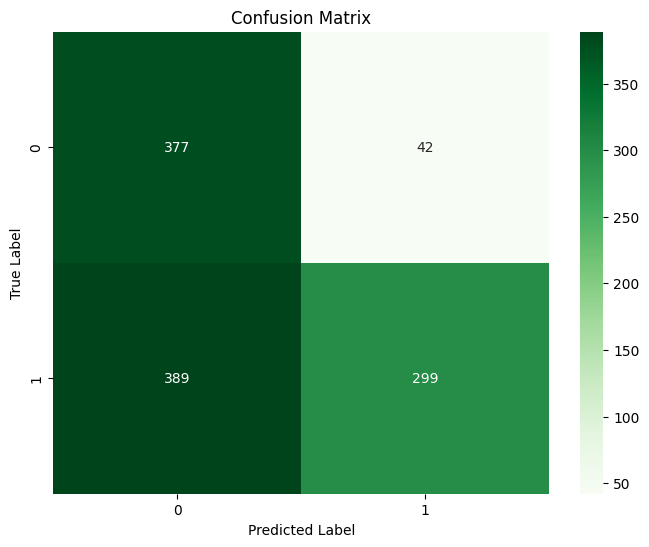

In [44]:
compute_metrics(result_df_3, "Greens")

In [45]:
# Save the DataFrame to a CSV file
result_df_1.to_csv('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_output_English_l1.csv', index=False)
result_df_2.to_csv('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_output_English_l2.csv', index=False)
result_df_3.to_csv('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_output_English_l3.csv', index=False)

Similarly, the output for test_label3.csv is found by simply changing the path.

---